In [61]:
# DO NOT MODIFY! helper functions and constants
import nbimporter
from p1 import cv2, np, plt, math
from p1 import get_parameters, Gauss2D, filter_image_vec
from p2 import edge_detection_nms

image_list, constants = get_parameters()

#----------------------------------------------------------------------
def visualize(image_name, constants):
    image_rgb = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
    print("-" * 50 + "\n" + "Original Image:")
    plt.imshow(image_rgb); plt.show() # Displaying the sample image
    
    image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    image_m, image_o, image_x, image_y = edge_detection_nms(image, constants.sigma)
    
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(image_m, cmap="gray"); plt.show() # Displaying the sample image
    
    image_m_thres = 1.0*(image_m > constants.thres) # threshold the edge magnitude image
    print("-" * 50 + "\n" + "Thresholded Edge Image:")
    plt.imshow(image_m_thres, cmap="gray"); plt.show() # Displaying the sample image
    
    #--------------hough transform----------------
    H, rho_arr, theta_arr = hough_transform(image_m, constants.thres, constants.rho_res, constants.theta_res)   
    peak_rho_arr, peak_theta_arr = peak_hough_lines(H, rho_arr, theta_arr, constants.num_lines)
    
    #--------------vis using infinitely long lines----------------------------
    vis_line_len = 1000 # len of line in pixels, big enough to span the image
    vis_image_rgb = np.copy(image_rgb)
    for (rho, theta) in zip(peak_rho_arr, peak_theta_arr):
        x0 = rho*np.cos(theta); y0 = rho*np.sin(theta)
        x1 = int(x0 - vis_line_len*np.sin(theta)); y1 = int(y0 + vis_line_len*np.cos(theta))
        x2 = int(x0 + vis_line_len*np.sin(theta)); y2 = int(y0 - vis_line_len*np.cos(theta)); 
        cv2.line(vis_image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    #---------------------------------------------
    print("-" * 50 + "\n" + "Edge Image:")
    plt.imshow(vis_image_rgb); plt.show() # Displaying the sample image
    
    return

### Q3.1 Hough Transform (15 points)

Write a function that applies the Hough Transform to an edge magnitude image.  

```
  def hough_transform(image_m, thres, rho_res, theta_res):
        return H, rho_arr, theta_arr
```

- **Input**: the edge magnitude image *$image\_m$*, scalar *$thres$* to threshold *$image\_m$* into a binary array, scalars *$rho\_res$* and *$theta\_res$* are the resolution of the Hough Transform accumulator along the $\rho$ and $\theta$ axes respectively.
- **Output**: *$H$* is the Hough Transform accumulator, *$rho\_arr$* and *$theta\_arr$* are the arrays of $\rho$ and $\theta$ values over which *$H$* is computed. 

**Instructions**
- Your code cannot call pre-existing functions for Hough Transform.
- We threshold the edge magnitude image first to identify pixels which likely are an edge
- rho_res is the resolution of the rho space, theta_res is the resolution of the theta space in degrees
- rho_arr goes from -rho_max to rho_max in rho_res steps, including the end points!
- theta_arr goes from 0 to pi in theta_res steps, including the end points! Note: theta_arr is in radians not degrees!
- Refer the slides for Hough Transform for the algorithm

**Grading**
- Your code will be autograded with 3 images. 
- The outputs of the function will be compared with the outputs of a reference implementation with an error threshold of 1e-5.

In [86]:
def hough_transform(image_m, thres, rho_res, theta_res):
    """Compute Hough Transform for the image

    Args:
        image_m: np.array, HxW, edge magnitude image.
        thres: float, scalar to threshold image_m
        rho_res: integer, resolution of rho
        theta_res: integer, resolution of theta in degrees
        
    Returns:
        H: np.array, (num of rhos x num of thetas), hough transform accumulator (rho x theta), NOT theta x rho!
        rho_arr: np.array, dim=num of rhos, quantized rhos
        theta_arr: np.array, dim=num of thetas, quantized thetas
    """
    
    image_m_thres = 1.0*(image_m > thres) # threshold the edge magnitude image
    height, width = image_m_thres.shape # image height and width 
    diagonal_len = np.ceil(np.sqrt(height**2 + width**2)) # image diagonal = rho_max   
    
    # compute rho_arr, we go from [-rho_max to rho_max] in rho_res steps
    # rho_arr = ?
    # YOUR CODE HERE
    rho_max = np.ceil(np.sqrt((height)**2 + (width)**2))
    rho_arr = np.arange(-rho_max, rho_max, step=rho_res)
    rho_arr = np.concatenate([rho_arr, [rho_max]])
    
    
    # compute theta_arr, we go from [0, pi] in theta_res steps, NOT [-pi/2, pi/2]!
    # Note theta_res is in degrees but theta_scale should be in radians [0, pi]
    # theta_arr = ?
    # YOUR CODE HERE
    theta_arr = np.arange(0, np.pi, step=np.radians(theta_res))
    theta_arr = np.concatenate([theta_arr, [np.pi]])
    
    H = np.zeros((len(rho_arr), len(theta_arr)), dtype=np.int32)
    
    # find all edge (nonzero) pixel indexes
    y_idxs, x_idxs = image_m_thres.nonzero() 
    
    for x, y in zip(x_idxs, y_idxs):
        for theta_idx, theta in enumerate(theta_arr):
            # compute rho_idx, note, theta is in radians!
            # Hint: compute rho first from theta, round it to nearest rho_prime in rho_arr
            # and then find rho_prime's rho_idx (index of rho_prime in rho_arr, NOT index of rho!)
            # rho_idx = ?
            phase_shift = np.arctan(np.divide(y, x)) if x != 0 else np.arctan(np.inf)
            rho = np.sqrt(x**2 + y**2) * np.sin(theta - phase_shift + np.pi / 2)
            distances = np.abs(rho_arr - rho)
            rho_idx = np.argmin(distances)
            
            H[rho_idx, theta_idx] += 1
    
    return H, rho_arr, theta_arr

### Q3.2 Finding Lines (5 points)
Write a function that outputs the indices of the local maxima in Hough Transform accumulator.

```
  def peak_hough_lines(H, rho_arr, theta_arr, num_lines):
        return peak_rho_arr, peak_theta_arr

```

- **Input**: *$H$* is the accumulator matrix (rhos x thetas), *$rho\_arr$* and *$theta\_arr$* are the quantized rho and theta arrays, *$num\_lines$* is a scalar - number of most prominent lines we wish to detect in the image.
- **Output**: *$peak\_rho\_arr$*, *$peak\_theta\_arr$* - top num_lines rhos and thetas.

**Instructions**
- Sort the accumulator H to obtain the top N(num_lines) lines
- Output the rho and theta corresponding to these lines
- We recommend using np.argsort for sorting. This ensures you have consistent tie breaks same as the reference implementation used by autograder.

**Grading** Same as Q3.1

In [87]:
def peak_hough_lines(H, rho_arr, theta_arr, num_lines):
    """Returns the rhos and thetas corresponding to top local maximas in the accumulator H

    Args:
        H: np.array, (num of rhos x num of thetas), hough transform accumulator
        rho_arr: np.array, dim=num of rhos, quantized rhos
        theta_arr: np.array, dim=num of thetas, quantized thetas
        num_lines: integer, number of lines we wish to detect in the image
        
    Returns:
        peak_rho_arr: np.array, dim=num_lines, top num_lines rhos by votes in the H
        peak_theta_arr: np.array, dim=num_lines, top num_lines thetas by votes in the H
    """
    
    # compute peak_rho_arr and peak_theta_arr
    # sort H using np.argsort, pick the top num_lines lines
    # peak_rho_arr = ?
    # peak_theta_arr = ?
    
    # YOUR CODE HERE
    rho_dim = H.shape[0]
    theta_dim = H.shape[1]
    size = rho_dim * theta_dim
    flattened_indices = np.argsort(H.flatten())[size - num_lines:]

    peak_rho_arr = np.array([rho_arr[n // theta_dim] for n in flattened_indices])
    peak_theta_arr = np.array([theta_arr[n % theta_dim] for n in flattened_indices])
    
    assert(len(peak_rho_arr) == num_lines)
    assert(len(peak_theta_arr) == num_lines)
    return peak_rho_arr, peak_theta_arr

### Test Q3.1 and Q3.2

--------------------------------------------------
Original Image:


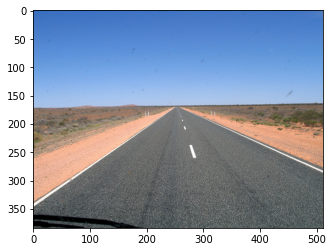

--------------------------------------------------
Edge Image:


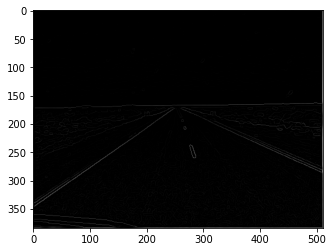

--------------------------------------------------
Thresholded Edge Image:


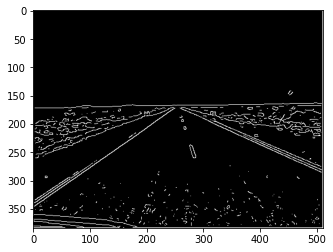

--------------------------------------------------
Edge Image:


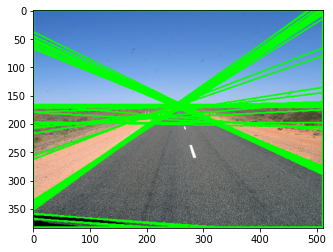

In [89]:
### Uncomment for visualization
image_idx = np.random.randint(0, len(image_list))
visualize(image_list[image_idx], constants)

### Autograde Q3.1
5 points per test case, 3 test cases

### Autograde Q3.2
5 points per test case, 1 test case